In [2]:
%matplotlib inline

from pathlib import Path

import numpy as np
import pandas as pd
import pandas_datareader.data as web
from scipy.stats import spearmanr

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow import keras

import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using GPU


In [5]:
sns.set_style('whitegrid')
np.random.seed(42)

In [15]:
pd.set_option('display.max_rows',None)

In [16]:
df = pd.read_csv('top10CC.csv').set_index('date')
df

,top10_Liquid,top10_Market
date,,
2018-01-07,"['BTC ', 'ETH ', 'XRP ', 'TRX ', 'QTUM ', 'BCH...","['BTC', 'XRP', 'ETH', 'BCH', 'ADA', 'XEM', 'LT..."
2018-01-14,"['BTC ', 'ETH ', 'XRP ', 'ETC ', 'EOS ', 'BCH ...","['BTC', 'ETH', 'XRP', 'BCH', 'ADA', 'LTC', 'XE..."
2018-01-21,"['BTC ', 'ETH ', 'EOS ', 'XRP ', 'QTUM ', 'ADA...","['BTC', 'ETH', 'XRP', 'BCH', 'ADA', 'LTC', 'XE..."
2018-01-28,"['BTC ', 'ETH ', 'XRP ', 'EOS ', 'BCH ', 'LTC ...","['BTC', 'ETH', 'XRP', 'BCH', 'ADA', 'XLM', 'LT..."
2018-02-04,"['BTC ', 'ETH ', 'XRP ', 'LTC ', 'SNT ', 'ADA ...","['BTC', 'ETH', 'XRP', 'BCH', 'ADA', 'LTC', 'NE..."
2018-02-11,"['BTC ', 'XRP ', 'ETH ', 'BCH ', 'LTC ', 'EOS ...","['BTC', 'ETH', 'XRP', 'BCH', 'ADA', 'LTC', 'XL..."
2018-02-18,"['BTC ', 'ETH ', 'XRP ', 'LTC ', 'BCH ', 'ETC ...","['BTC', 'ETH', 'XRP', 'BCH', 'LTC', 'ADA', 'XL..."
2018-02-25,"['BTC ', 'ETH ', 'LTC ', 'ETC ', 'BCH ', 'XRP ...","['BTC', 'ETH', 'XRP', 'BCH', 'LTC', 'ADA', 'NE..."
2018-03-04,"['BTC ', 'ETH ', 'XRP ', 'ETC ', 'LTC ', 'BCH ...","['BTC', 'ETH', 'XRP', 'BCH', 'LTC', 'ADA', 'NE..."


# For any time T (starting from Jan 1st  2020) in the test set, we have the top 10 CC in time T. For each CC, we train the model using data from 2017 to 2019. And use the model to predict the return of time (T+1) given the data of T-90 to T.

## Detailed Steps:
### find all the top10 CC from Jan 2020 and train each model using data from 2017 to 2019.
### Then for each day T after Jan 2020, we find the top10 CC and combine the exising models with their data of T-90 to T to predict T+1. 
### Then fit the return of T+1 to into mean-variance model to get the optimal CC allocation
### Then test the performance of the strategy

In [13]:
TEST_START = '2020-01-01'
df.loc[TEST_START]

KeyError: '2020-01-01'

# Get Data

In [110]:
df=pd.read_csv('CC_daily_data.csv').dropna()
dfclose = df[df['ticker']=='ETH-USD'].set_index(['date'])['close'].to_frame()
dfclose = dfclose[~dfclose.index.duplicated(keep = 'first')]
dfclose

,close
date,
2017-01-01,8.172570
2017-01-02,8.378510
2017-01-03,9.725250
2017-01-04,11.251600
2017-01-05,10.254400
...,...
2020-12-26,635.835815
2020-12-27,682.642334
2020-12-28,730.397339


In [111]:
dfreturn = (np.log(dfclose/dfclose.shift())
            .dropna()
            .rename(columns = {'close':'return'}))
dfreturn

,return
date,
2017-01-02,0.024887
2017-01-03,0.149055
2017-01-04,0.145785
2017-01-05,-0.092803
2017-01-06,0.000029
...,...
2020-12-26,0.014934
2020-12-27,0.071031
2020-12-28,0.067618


In [112]:
results_path = Path('results', 'univariate_LSTM')
if not results_path.exists():
    results_path.mkdir(parents=True)

# Predicting Future Price:

# Preprocessing

In [113]:
scaler = MinMaxScaler()
dfclose_scaled = pd.Series(scaler.fit_transform(dfclose).squeeze(),index =dfclose.index)
dfclose_scaled.describe()

count    1452.000000
mean        0.209548
std         0.161662
min         0.000000
25%         0.109367
50%         0.159265
75%         0.269770
max         1.000000
dtype: float64

# Generating recurrent sequences from the time series

We will generate sequences of 90 trading days, approximately 3 months, and use a single LSTM layer with 10 hidden units to predict the index value one timestep ahead. 
The input to every LSTM layer must have three dimensions, namely:
- **Samples**: One sequence is one sample. A batch contains one or more samples.
- **Time Steps**: One time step is one point of observation in the sample.
- **Features**: One feature is one observation at a time step.

In [114]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y


In [115]:
window_size = 90

In [116]:
X,y = create_univariate_rnn_data(dfclose_scaled, window_size)

In [117]:
X.shape

(1362, 90)

# Train-test split

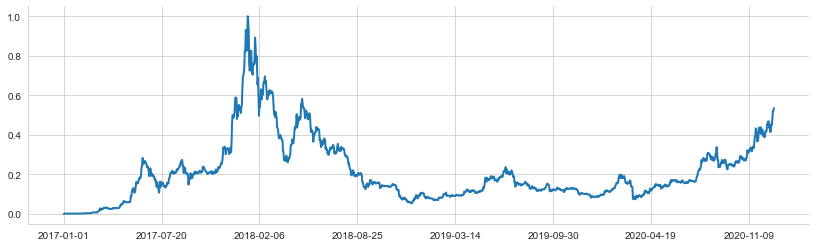

In [118]:
ax = dfclose_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [119]:
X_train = X[:'2020'].values.reshape(-1, window_size, 1)
y_train = y[:'2020']

# keep the last year for testing
X_test = X['2020':].values.reshape(-1, window_size, 1)
y_test = y['2020':]

In [120]:
n_obs, window_size, n_features = X_train.shape

In [121]:
y_train.shape

(1002,)

# Define Model Architechture

In [122]:
rnn_price = Sequential([
    LSTM(units = 10, input_shape = (window_size,n_features), name='LSTM'),
    Dense(1, name='Output')
])

In [123]:
rnn_price.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 10)                480       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


# Train the Model

In [124]:
optimizer = keras.optimizers.RMSprop(lr=.001, rho = .9, epsilon = 1e-08, decay = .0)
rnn_price.compile(loss = 'mean_squared_error', optimizer = optimizer)

In [125]:
rnn_path = (results_path / 'rnn.h5').as_posix()
checkpointer = ModelCheckpoint(filepath=rnn_path,verbose=1,monitor='val_loss',save_best_only=True)

In [126]:
early_stopping = EarlyStopping(monitor = 'val_loss',patience = 20, restore_best_weights = True)

In [127]:
lstm_training_price = rnn_price.fit(X_train,y_train, epochs = 150, batch_size = 20, shuffle = True, validation_data=(X_test,y_test),callbacks = [early_stopping,checkpointer],verbose =1)

Epoch 1/150
51/51 [==============================] - 3s 26ms/step - loss: 0.0304 - val_loss: 0.0010

Epoch 00001: val_loss improved from inf to 0.00103, saving model to results/univariate_LSTM\rnn.h5
Epoch 2/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0024 - val_loss: 0.0019

Epoch 00002: val_loss did not improve from 0.00103
Epoch 3/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0017 - val_loss: 4.1361e-04

Epoch 00003: val_loss improved from 0.00103 to 0.00041, saving model to results/univariate_LSTM\rnn.h5
Epoch 4/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0014 - val_loss: 3.7380e-04

Epoch 00004: val_loss improved from 0.00041 to 0.00037, saving model to results/univariate_LSTM\rnn.h5
Epoch 5/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0012 - val_loss: 5.1847e-04

Epoch 00005: val_loss did not improve from 0.00037
Epoch 6/150
51/51 [==============================] - 1s 11ms/step - loss: 0.

51/51 [==============================] - 1s 11ms/step - loss: 3.3034e-04 - val_loss: 1.5517e-04

Epoch 00097: val_loss did not improve from 0.00014
Epoch 98/150
51/51 [==============================] - 1s 11ms/step - loss: 3.2476e-04 - val_loss: 1.4632e-04

Epoch 00098: val_loss did not improve from 0.00014
Epoch 99/150
51/51 [==============================] - 1s 11ms/step - loss: 3.6065e-04 - val_loss: 3.1315e-04

Epoch 00099: val_loss did not improve from 0.00014
Epoch 100/150
51/51 [==============================] - 1s 11ms/step - loss: 3.8282e-04 - val_loss: 4.0507e-04

Epoch 00100: val_loss did not improve from 0.00014
Epoch 101/150
51/51 [==============================] - 1s 11ms/step - loss: 3.6474e-04 - val_loss: 1.3355e-04

Epoch 00101: val_loss improved from 0.00014 to 0.00013, saving model to results/univariate_LSTM\rnn.h5
Epoch 102/150
51/51 [==============================] - 1s 10ms/step - loss: 3.2101e-04 - val_loss: 6.1092e-04

Epoch 00102: val_loss did not improve from 

51/51 [==============================] - 1s 11ms/step - loss: 3.4551e-04 - val_loss: 1.6973e-04

Epoch 00146: val_loss did not improve from 0.00013
Epoch 147/150
51/51 [==============================] - 1s 11ms/step - loss: 3.9733e-04 - val_loss: 1.2830e-04

Epoch 00147: val_loss did not improve from 0.00013
Epoch 148/150
51/51 [==============================] - 1s 11ms/step - loss: 3.5320e-04 - val_loss: 1.3664e-04

Epoch 00148: val_loss did not improve from 0.00013
Epoch 149/150
51/51 [==============================] - 1s 11ms/step - loss: 4.9140e-04 - val_loss: 1.2751e-04

Epoch 00149: val_loss did not improve from 0.00013
Epoch 150/150
51/51 [==============================] - 1s 11ms/step - loss: 2.9808e-04 - val_loss: 1.3302e-04

Epoch 00150: val_loss did not improve from 0.00013


# Evaluate model performance

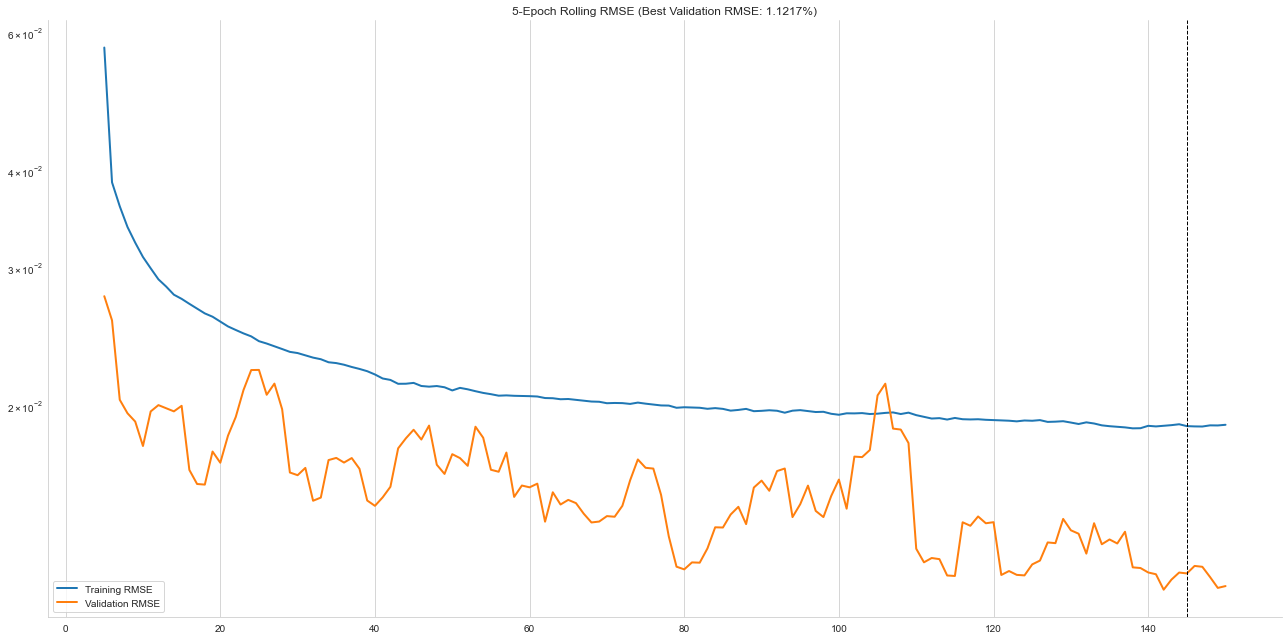

In [128]:
fig, ax = plt.subplots(figsize=(18, 9))

loss_history = pd.DataFrame(lstm_training_price.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_cc_error', dpi=300);

In [129]:
train_rmse_scaled = np.sqrt(rnn_price.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn_price.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0181 | Test RMSE: 0.0115


In [130]:
train_predict_scaled = rnn_price.predict(X_train)
test_predict_scaled = rnn_price.predict(X_test)

In [131]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.9946 | Test IC: 0.9903


# Rescale predictions

In [132]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict =  pd.Series(scaler.inverse_transform(test_predict_scaled) .squeeze(), index=y_test.index)

In [133]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [134]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
print(f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}')

Train RMSE: 25.19 | Test RMSE: 16.01


In [135]:
dfclose['Train Predictions'] = train_predict
dfclose['Test Predictions'] = test_predict
dfclose = dfclose.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

In [136]:
dfclose

,close,Train Predictions,Test Predictions,predictions,data
date,,,,,
2017-01-01,8.172570,NaN,NaN,NaN,NaN
2017-01-02,8.378510,NaN,NaN,NaN,NaN
2017-01-03,9.725250,NaN,NaN,NaN,NaN
2017-01-04,11.251600,NaN,NaN,NaN,NaN
2017-01-05,10.254400,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-12-26,635.835815,NaN,619.534912,619.534912,Test
2020-12-27,682.642334,NaN,630.896301,630.896301,Test
2020-12-28,730.397339,NaN,676.222351,676.222351,Test


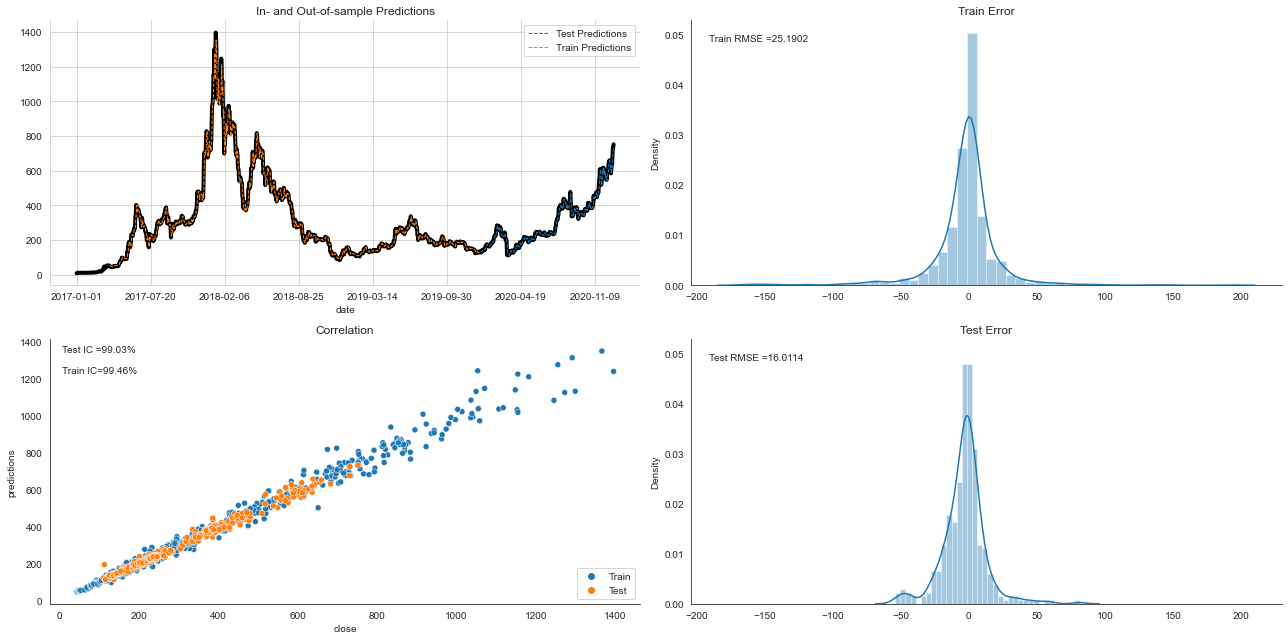

In [137]:
fig=plt.figure(figsize=(18,9))
ax1 = plt.subplot(221)

dfclose.loc['2017':, 'close'].plot(lw=4, ax=ax1, c='k')
dfclose.loc['2017':, ['Test Predictions', 'Train Predictions']].plot(lw=1, ax=ax1, ls='--')
ax1.set_title('In- and Out-of-sample Predictions')


with sns.axes_style("white"):
    ax3 = plt.subplot(223)
    sns.scatterplot(x='close', y='predictions', data=dfclose, hue='data', ax=ax3)
    ax3.text(x=.02, y=.95, s=f'Test IC ={test_ic:.2%}', transform=ax3.transAxes)
    ax3.text(x=.02, y=.87, s=f'Train IC={train_ic:.2%}', transform=ax3.transAxes)
    ax3.set_title('Correlation')
    ax3.legend(loc='lower right')
    
    ax2 = plt.subplot(222)
    ax4 = plt.subplot(224, sharex = ax2, sharey=ax2)
    sns.distplot(train_predict.squeeze()- y_train_rescaled, ax=ax2)
    ax2.set_title('Train Error')
    ax2.text(x=.03, y=.92, s=f'Train RMSE ={train_rmse:.4f}', transform=ax2.transAxes)
    sns.distplot(test_predict.squeeze()-y_test_rescaled, ax=ax4)
    ax4.set_title('Test Error')
    ax4.text(x=.03, y=.92, s=f'Test RMSE ={test_rmse:.4f}', transform=ax4.transAxes)

sns.despine()
fig.tight_layout()
# fig.savefig(results_path / 'rnn_cc_regression', dpi=300);

In [138]:
model_test = dfclose.copy()
ar = np.log(model_test['close']/model_test['close'].shift()).fillna(0)
pr = np.log(model_test['predictions'] / model_test['close'].shift()).fillna(0)
tmp = ar*pr[-30:]
accuracy = len(tmp[tmp>0])/30
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.43


# Predicting Future Returns:

# Preprocessing

In [139]:
scaler = MinMaxScaler()
dfreturn_scaled = pd.Series(scaler.fit_transform(dfreturn).squeeze(),index =dfreturn.index)
dfreturn_scaled.describe()

count    1451.000000
mean        0.658655
std         0.067413
min         0.000000
25%         0.630847
50%         0.656575
75%         0.686914
max         1.000000
dtype: float64

# Generating recurrent sequences from the time series

In [140]:
def create_univariate_rnn_data(data, window_size):
    n = len(data)
    y = data[window_size:]
    data = data.values.reshape(-1, 1) # make 2D
    X = np.hstack(tuple([data[i: n-j, :] for i, j in enumerate(range(window_size, 0, -1))]))
    return pd.DataFrame(X, index=y.index), y

In [141]:
window_size = 90

In [142]:
X,y = create_univariate_rnn_data(dfreturn_scaled, window_size)

In [143]:
X.shape

(1361, 90)

# Train-test split

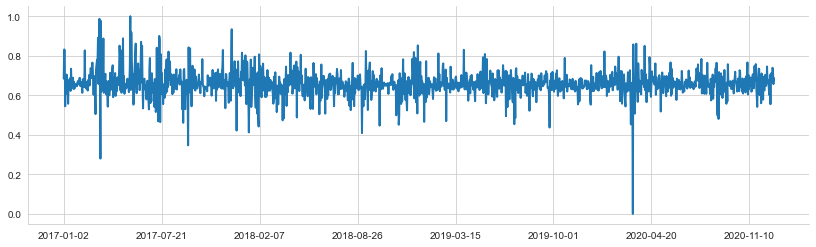

In [144]:
ax = dfreturn_scaled.plot(lw=2, figsize=(14, 4), rot=0)
ax.set_xlabel('')
sns.despine()

In [145]:
X_train = X[:'2020'].values.reshape(-1, window_size, 1)
y_train = y[:'2020']

# keep the last year for testing
X_test = X['2020':].values.reshape(-1, window_size, 1)
y_test = y['2020':]

In [146]:
n_obs, window_size, n_features = X_train.shape

In [147]:
y_train.shape

(1001,)

# Define Model Architechture

In [148]:
rnn_return = Sequential([
    LSTM(units = 10, input_shape = (window_size,n_features), name='LSTM'),
    Dense(1, name='Output')
])

In [149]:
rnn_return.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM (LSTM)                  (None, 10)                480       
_________________________________________________________________
Output (Dense)               (None, 1)                 11        
Total params: 491
Trainable params: 491
Non-trainable params: 0
_________________________________________________________________


# Train the Model

In [150]:
rnn_return.compile(loss = 'mean_squared_error', optimizer = optimizer)

In [151]:
lstm_training_return = rnn_return.fit(X_train,y_train, epochs = 150, batch_size = 20, shuffle = True, validation_data=(X_test,y_test),callbacks = [early_stopping,checkpointer],verbose =1)

Epoch 1/150
51/51 [==============================] - 3s 28ms/step - loss: 0.1300 - val_loss: 0.0060

Epoch 00001: val_loss did not improve from 0.00013
Epoch 2/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0051 - val_loss: 0.0061

Epoch 00002: val_loss did not improve from 0.00013
Epoch 3/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0048 - val_loss: 0.0046

Epoch 00003: val_loss did not improve from 0.00013
Epoch 4/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0046 - val_loss: 0.0079

Epoch 00004: val_loss did not improve from 0.00013
Epoch 5/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0055 - val_loss: 0.0086

Epoch 00005: val_loss did not improve from 0.00013
Epoch 6/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0050 - val_loss: 0.0042

Epoch 00006: val_loss did not improve from 0.00013
Epoch 7/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0045 - val_l


Epoch 00054: val_loss did not improve from 0.00013
Epoch 55/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0044 - val_loss: 0.0053

Epoch 00055: val_loss did not improve from 0.00013
Epoch 56/150
51/51 [==============================] - 1s 11ms/step - loss: 0.0047 - val_loss: 0.0041

Epoch 00056: val_loss did not improve from 0.00013


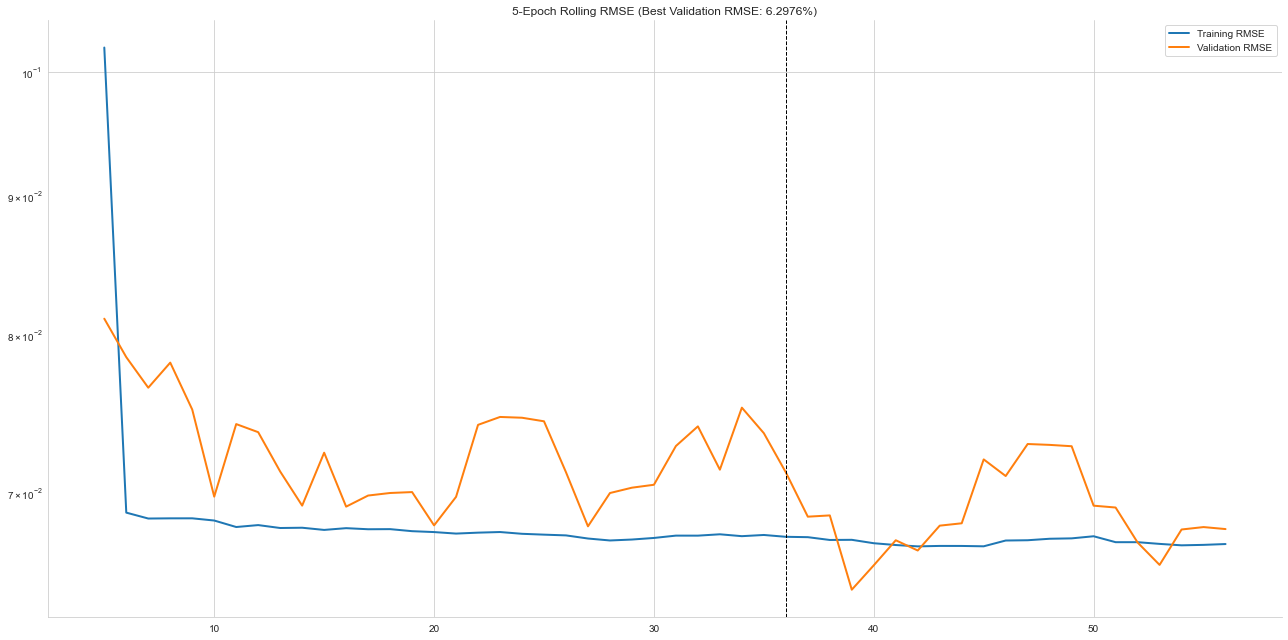

In [152]:
fig, ax = plt.subplots(figsize=(18, 9))

loss_history = pd.DataFrame(lstm_training_return.history).pow(.5)
loss_history.index += 1
best_rmse = loss_history.val_loss.min()

best_epoch = loss_history.val_loss.idxmin()

title = f'5-Epoch Rolling RMSE (Best Validation RMSE: {best_rmse:.4%})'
loss_history.columns=['Training RMSE', 'Validation RMSE']
loss_history.rolling(5).mean().plot(logy=True, lw=2, title=title, ax=ax)

ax.axvline(best_epoch, ls='--', lw=1, c='k')

sns.despine()
fig.tight_layout()
fig.savefig(results_path / 'rnn_cc_error', dpi=300);

In [153]:
train_rmse_scaled = np.sqrt(rnn_return.evaluate(X_train, y_train, verbose=0))
test_rmse_scaled = np.sqrt(rnn_return.evaluate(X_test, y_test, verbose=0))
print(f'Train RMSE: {train_rmse_scaled:.4f} | Test RMSE: {test_rmse_scaled:.4f}')

Train RMSE: 0.0662 | Test RMSE: 0.0630


In [154]:
train_predict_scaled = rnn_return.predict(X_train)
test_predict_scaled = rnn_return.predict(X_test)

In [155]:
train_ic = spearmanr(y_train, train_predict_scaled)[0]
test_ic = spearmanr(y_test, test_predict_scaled)[0]
print(f'Train IC: {train_ic:.4f} | Test IC: {test_ic:.4f}')

Train IC: 0.0761 | Test IC: -0.0480


# Rescale predictions

In [156]:
train_predict = pd.Series(scaler.inverse_transform(train_predict_scaled).squeeze(), index=y_train.index)
test_predict = (pd.Series(scaler.inverse_transform(test_predict_scaled).squeeze(), index=y_test.index))

In [157]:
y_train_rescaled = scaler.inverse_transform(y_train.to_frame()).squeeze()
y_test_rescaled = scaler.inverse_transform(y_test.to_frame()).squeeze()

In [158]:
train_rmse = np.sqrt(mean_squared_error(train_predict, y_train_rescaled))
test_rmse = np.sqrt(mean_squared_error(test_predict, y_test_rescaled))
f'Train RMSE: {train_rmse:.2f} | Test RMSE: {test_rmse:.2f}'

'Train RMSE: 0.06 | Test RMSE: 0.05'

In [159]:
dfreturn['Train Predictions'] = train_predict
dfreturn['Test Predictions'] = test_predict
dfreturn = dfreturn.join(train_predict.to_frame('predictions').assign(data='Train')
                        .append(test_predict.to_frame('predictions').assign(data='Test')))

In [160]:
dfreturn

,return,Train Predictions,Test Predictions,predictions,data
date,,,,,
2017-01-02,0.024887,NaN,NaN,NaN,NaN
2017-01-03,0.149055,NaN,NaN,NaN,NaN
2017-01-04,0.145785,NaN,NaN,NaN,NaN
2017-01-05,-0.092803,NaN,NaN,NaN,NaN
2017-01-06,0.000029,NaN,NaN,NaN,NaN
...,...,...,...,...,...
2020-12-26,0.014934,NaN,0.004681,0.004681,Test
2020-12-27,0.071031,NaN,0.005273,0.005273,Test
2020-12-28,0.067618,NaN,0.007678,0.007678,Test


In [161]:
model_test = dfreturn.copy().fillna(0)
tmp = model_test['return']*model_test['predictions'][-30:]
accuracy = len(tmp[tmp>0])/30
print(f'Test accuracy: {accuracy:.2f}')

Test accuracy: 0.67
